In [1]:
from Bio import Phylo
from Bio import SeqIO
from Bio.Alphabet import IUPAC
import os
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
import shutil

In [2]:
fasta_path = "input/orthoExon_fasta/"
output_path = "output/"
tree_fn = "input/tapir_ref_959genes.tre"

In [3]:
def closest_available_relative(sp, avail_set, terminals, tree):
    pairs = ((terminals[sp], terminals[c]) for c in avail_set)
    return sorted([(i[1].name,tree.distance(*i)) for i in pairs], key=lambda x: x[1])[0]

In [4]:
tree = Phylo.read(tree_fn, 'newick')
tree.ladderize()   # Flip branches so deeper clades are displayed at top

sp_list = [cl.name for cl in tree.get_terminals()]
sp_set = set(sp_list)
terminals = {l.name:l for l in tree.get_terminals()}

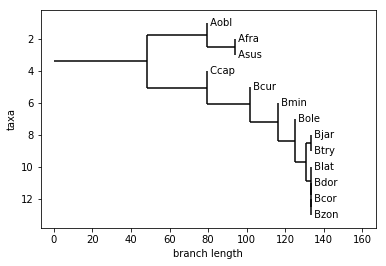

In [5]:
Phylo.draw(tree)

In [6]:
# create handles for all .fasta files in fasta directory
fasta_fn = {name.split('.')[0]: fasta_path + name for name in
                    os.listdir(fasta_path) if
                    ((".fasta" in name) and (".fai" not in name))}

# read and parse fasta files for each species
fasta = {}
for ortho in fasta_fn.keys():
    fasta[ortho] = {seq_record.id: seq_record
                            for seq_record in SeqIO.parse(fasta_fn[ortho],
                                                          "fasta", alphabet=IUPAC.ambiguous_dna)}

In [7]:
shutil.rmtree(output_path, ignore_errors=True)
os.makedirs(output_path, exist_ok=True)

for ortho in fasta.keys():
    avail_set = set(fasta[ortho].keys())
    missing_set = sp_set - avail_set
    with open(output_path + ortho + ".padded.fasta", "wt") as f:
        for sp in sp_list:
            if sp in missing_set:
                sub_sp, distance = closest_available_relative(sp, avail_set, terminals, tree)
                sub_seq = fasta[ortho][sub_sp].seq
                description = "subbed-missing-with_{} distance_{}".format(sub_sp, distance)
                seqRec = SeqRecord(sub_seq, id=sp, description=description)
                f.write(seqRec.format("fasta"))
            else:
                f.write(fasta[ortho][sp].format("fasta"))